#### Pytorch Built-in Transformer on IC

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.distributions as dist
import torch.optim as optim

from torch.utils.data import DataLoader
import sys
import os

#Custom
import utilities

#### Import Dataset, Calculate Means and Covariances of Bonds and Angles

In [3]:
MMCD_path = "./"
sys.path.append(MMCD_path)
from mmcd import MMCDataset

name = 'dialanine'
data_path = os.path.join(MMCD_path, "data")

dataset_train = MMCDataset(root = data_path,
                           molecule_name = name,
                           train = True,
                           coordinate_type = 'internal',
                           lazy_load = False)

whole_loader = DataLoader(dataset_train,
                          num_workers = 1,
                          batch_size = 160000, #256 is the default batch size
                          shuffle = True)

train_loader = DataLoader(dataset_train,
                          num_workers = 1,
                          batch_size = 256, #256 is the default batch size
                          shuffle = True)

for batch_idx, (data, _) in enumerate(whole_loader):
    #Flatten the data into a tensor of size (256, 60) tensor before putting it into the GPU
    data = utilities.flatten_data(data)
    tr_cov, tr_means, bonds_angles_dist = utilities.return_ba_mean_covar(data)
    break

del tr_cov, tr_means, whole_loader

In [5]:
class DecoderLayer(nn.Module):
    """Implements a single layer of an unconditional ImageTransformer"""
    def __init__(self):
        self.hidden_size = 128
        self.filter_size = 256
        self.unconditional = False

        super().__init__()
        self.attn = Attn()
        self.dropout = nn.Dropout(p=0.02)
        self.layernorm_attn = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        self.layernorm_attn2 = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        self.layernorm_ffn = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        self.ffn = nn.Sequential(nn.Linear(self.hidden_size, self.filter_size, bias=True), nn.ReLU(),
                                 nn.Linear(self.filter_size, self.hidden_size, bias=True))

    def forward(self, X, encoder_output = None):
        #the first layer of a decoder is just normal self-attention
        y = self.attn(X, use_encoder_output = False, autoregressive_mask = True)
        X = self.layernorm_attn(self.dropout(y) + X)
        #the second layer of a decoder uses outputs from the encoder as query and key values
        y = self.attn(X, encoder_output = encoder_output, 
            use_encoder_output = True, autoregressive_mask = True)
        X = self.layernorm_attn2(self.dropout(y) + X)
        #the last layer is just feed forward and layer norm
        y = self.ffn(X)
        X = self.layernorm_ffn(self.dropout(y) + X)
        return X

class EncoderLayer(nn.Module):
    "The encoder is also identical to the decoder, except that the decoder has masking operation" 
    def __init__(self):
        self.hidden_size = 128
        self.filter_size = 256

        super().__init__()
        self.attn = Attn()
        self.dropout = nn.Dropout(p=0.02)
        self.layernorm_attn = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        self.layernorm_ffn = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        self.ffn = nn.Sequential(nn.Linear(self.hidden_size, self.filter_size, bias=True),
                                 nn.ReLU(), nn.Linear(self.filter_size, self.hidden_size, bias=True))

    def forward(self, X):
        y = self.attn(X)
        X = self.layernorm_attn(self.dropout(y) + X)
        y = self.ffn(X)
        X = self.layernorm_ffn(self.dropout(y) + X)
        return X

class Attn(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = 128
        self.kd = 64
        self.vd = 64
        self.num_heads = 4
        self.attn_type = "global"

        self.q_dense = nn.Linear(self.hidden_size, self.kd, bias=False)
        self.k_dense = nn.Linear(self.hidden_size, self.kd, bias=False)
        self.v_dense = nn.Linear(self.hidden_size, self.vd, bias=False)

        self.output_dense = nn.Linear(self.vd, self.hidden_size, bias=False)
        assert self.kd % self.num_heads == 0
        assert self.vd % self.num_heads == 0

    def dot_product_attention(self, q, k, v, bias=None):
        logits = torch.einsum("...kd,...qd->...qk", k, q)
        if bias is not None:
            logits += bias
        weights = F.softmax(logits, dim=-1)
        return weights @ v

    def forward(self, X, encoder_output=None, autoregressive_mask = True, use_encoder_output=False):
        if use_encoder_output == False: 
            q = self.q_dense(X)
            k = self.k_dense(X)
            v = self.v_dense(X)
        elif use_encoder_output == True: 
            v = self.v_dense(X)
            q = encoder_output.clone()
            k = encoder_output.clone()

        #Split to shape [batch_size, num_heads, len, depth / num_heads]
        q = q.view(q.shape[:-1] + (self.num_heads, self.kd // self.num_heads)).permute([0, 2, 1, 3])
        k = k.view(k.shape[:-1] + (self.num_heads, self.kd // self.num_heads)).permute([0, 2, 1, 3])
        v = v.view(v.shape[:-1] + (self.num_heads, self.vd // self.num_heads)).permute([0, 2, 1, 3])
        q *= (self.kd // self.num_heads) ** (-0.5) #normalized dot product or something

        if self.attn_type == "global" and autoregressive_mask == True: 
            bias = -1e9 * torch.triu(torch.ones(X.shape[1], X.shape[1]), 1).to(X.device)
            result = self.dot_product_attention(q, k, v, bias=bias)
        elif self.attn_type == "global" and autoregressive_mask == False: 
            result = self.dot_product_attention(q, k, v, bias=None)


        result = result.permute([0, 2, 1, 3]).contiguous()
        result = result.view(result.shape[0:2] + (-1,))
        result = self.output_dense(result)

        return result

class TransformerIC(nn.Module):
    def __init__(self, pre_bonds_angles_dist, batch_size = 256):
        super(TransformerIC, self).__init__()
        #model specific params
        self.hidden_size = 128
        self.num_bins = 629 
        self.dropout = 0.05
        self.nlayers = 8
        #data specific params
        self.batch_size = 256
        self.ba_count = 41
        self.num_dihedrals = 19 #19
        self.ba_dist = pre_bonds_angles_dist
        #functions
        self.output_function = torch.nn.Softmax(dim=1)
        self.loss_function = nn.CrossEntropyLoss()
        #model components
        self.ba_embeds = nn.Linear(self.ba_count, self.hidden_size*self.ba_count)
        self.embeds = nn.Embedding(self.num_bins, self.hidden_size)
        self.input_dropout = nn.Dropout(self.dropout)
        self.output_dense = nn.Linear(self.hidden_size, self.num_bins, bias=True)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(self.nlayers)])
        self.encoderlayers = nn.ModuleList([EncoderLayer() for _ in range(self.nlayers)])
        #bond and angle sampling
        self.ba_dist = pre_bonds_angles_dist
        #reshape encoder output
        self.vd = 64
        self.encoder_reshape = nn.Linear(self.hidden_size, self.vd, bias=False)
        self.encoder_reshape2 = nn.Linear(self.ba_count, self.num_dihedrals, bias=False)
    
    def add_timing_signal(self, X, min_timescale=1.0, max_timescale=45.0):
        """Positional encoding"""
        num_dims = len(X.shape) - 2 # 2 corresponds to batch and hidden_size dimensions
        num_timescales = self.hidden_size // (num_dims * 2)
        log_timescale_increment = np.log(max_timescale / min_timescale) / (num_timescales - 1)
        inv_timescales = min_timescale * torch.exp((torch.arange(num_timescales).float() * -log_timescale_increment))
        inv_timescales = inv_timescales.to(X.device)
        total_signal = torch.zeros_like(X) # Only for debugging purposes
        for dim in range(num_dims):
            length = X.shape[dim + 1] # add 1 to exclude batch dim
            position = torch.arange(length).float().to(X.device)
            scaled_time = position.view(-1, 1) * inv_timescales.view(1, -1)
            signal = torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], 1)
            prepad = dim * 2 * num_timescales
            postpad = self.hidden_size - (dim + 1) * 2 * num_timescales
            signal = F.pad(signal, (prepad, postpad))
            for _ in range(1 + dim):
                signal = signal.unsqueeze(0)
            for _ in range(num_dims - 1 - dim):
                signal = signal.unsqueeze(-2)
            X += signal
            total_signal += signal
        return X

    def shift_and_pad_(self, X): 
        """   For the purpose of autoregressive property. Shift inputs over by 1 and pad.
        x should be [256, 19, 8]. Pad 2nd to last dimension, 
        since 1st dimension is batch and last is embedding. """
        X = X[:, :-1, :]
        X = F.pad(X, (0, 0, 1, 0)) #kinda need to figure out how this works
        return X

    def forward(self, dihedrals, ba = None, encoder_output = None, sampling = False, return_encoder = False):
        if encoder_output == None:
            encoder_output = self.ba_embeds(ba).view((ba.shape[0], self.ba_count, self.hidden_size)) * (self.hidden_size ** 0.5)
            encoder_output = self.add_timing_signal(encoder_output)
            for layer in self.encoderlayers:
                encoder_output = layer(encoder_output)
            encoder_output = self.encoder_reshape(encoder_output)
            encoder_output = encoder_output.permute(0, 2, 1) #now its [256, 8, 41]
            encoder_output = self.encoder_reshape2(encoder_output)
            encoder_output = encoder_output.permute(0, 2, 1)
            #print("Encoder output size", encoder_output.size())
            if return_encoder == True:
                return encoder_output
    
        if sampling:
            curr_infer_length = dihedrals.shape[1]
            dihedrals = F.pad(dihedrals, (0, self.num_dihedrals - curr_infer_length))  
        
        dihedrals = self.embeds(dihedrals) * (self.hidden_size ** 0.5)
        dihedrals = self.shift_and_pad_(dihedrals)
        dihedrals = self.add_timing_signal(dihedrals)
        
        for layer in self.layers:
            dihedrals = layer(dihedrals, encoder_output = encoder_output) 
    
        dihedrals = self.output_dense(dihedrals) 

        return dihedrals

    def sample(self, batch_size, device, conditional = True, argmax=False): #batch size is num samples
        if conditional == True:
            ba_data = self.ba_dist.sample(torch.tensor([batch_size])).to(device).float()
            encoder_output = self.forward(dihedrals=None, ba = ba_data, return_encoder=True)
        else:
            raise NotImplementedError

        total_len = self.num_dihedrals
        samples = torch.zeros( (batch_size, 1) ).to(device).long()

        for curr_infer_length in range(total_len):
            outputs = self.forward(encoder_output = encoder_output, dihedrals = samples, sampling=True)
            outputs = outputs[:, curr_infer_length]

            categorical = self.output_function(outputs) #outputs is energy
            temp_distribution = dist.Categorical(torch.squeeze(categorical))
            x = temp_distribution.sample()
            
            x = x.unsqueeze(dim=1)#print(categorical.size()) = [10, 629]
            
            if curr_infer_length == 0:
                samples = x
            else:
                samples = torch.cat([samples, x], 1)
            
        return samples

    def loss(self, X, Y, tensor_form = False):
        #X is a categorical distribution and Y is the target (one hot encoding).
        X = X.permute(0, 2, 1)
        #X.size() = [256, 19, 629] after permuting; Y.size() = [256, 19]
        #256 = batchsize, 629 = number classes, 19 = number of dihedrals
        loss_value = self.loss_function(X, Y) #nn.CrossEntropyLoss automatically applies softmax
        return loss_value        

device = torch.device("cuda")
model = TransformerIC(pre_bonds_angles_dist = bonds_angles_dist).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)  #lr is step size, arbitrarily picked.

#### Training Loop

In [8]:
loss_over_time = []
results = []

def train(epoch):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = utilities.flatten_data(data)
        data = data.to(device)

        bonds_angles = data[:, :-19]
        dihedrals = data[:, 41:]
        dihedrals = utilities.number_to_vec_class(dihedrals)
        true_target = dihedrals

        optimizer.zero_grad()
        X_pred = model(ba=bonds_angles, dihedrals=dihedrals) 
        loss = model.loss(X = X_pred, Y = true_target)

        if batch_idx % 25 == 0:#args.log_interval == 0: #by default, args.log_interval = 10
            print('Train Epoch:', epoch, '[{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx, #index of the batch we are on 
                len(train_loader), #how many batches are in the data loader
                100. * batch_idx / len(train_loader), #progress percentage
                loss.item() / len(train_loader))#,  #hardcoded batch size
                )
        
            loss_over_time.append(loss.item()/len(train_loader) )
            torch.set_printoptions(threshold=10_000)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

for epoch in range(0, 9, 1):
    train(epoch)
    '''
    sample =  model.sample(1000)
    sample = rebuild(sample)
    potential_energy_q_theta = dataset_train.compute_potential_energy_for_ic(sample)
    print(np.sum(potential_energy_q_theta)/1000)
    '''

Train Epoch: 0 [0/625 (0%)]	Loss: 0.007287
Train Epoch: 0 [25/625 (4%)]	Loss: 0.007106
Train Epoch: 0 [50/625 (8%)]	Loss: 0.007054
Train Epoch: 0 [75/625 (12%)]	Loss: 0.007049
Train Epoch: 0 [100/625 (16%)]	Loss: 0.007040
Train Epoch: 0 [125/625 (20%)]	Loss: 0.007017


KeyboardInterrupt: 

45


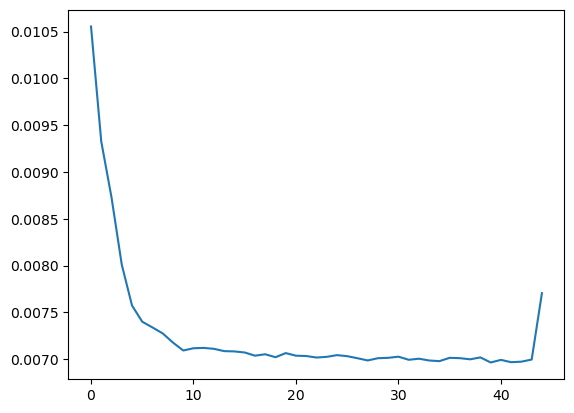

In [7]:
ls = np.array(loss_over_time)
print(np.size(ls))
plt.plot(ls)
plt.show()

### Sample From Model to View Distribtuions

In [11]:
sample_loader = DataLoader(dataset_train,
                          num_workers = 4,
                          batch_size = 3000, #256 is the default batch size
                          shuffle = True)

for batch_idx, (data, _) in enumerate(sample_loader):
    data = utilities.flatten_data(data)
    np_data = np.array(data)
    break

device = torch.device("cpu")
model = model.to(device)

samples_og = model.sample(2000, device=device)
samples = utilities.index_to_number(samples_og)
np_samples = np.array(samples.cpu().detach())
#ba = ba.cpu().numpy()

KeyboardInterrupt: 

#### View IC

In [ ]:
"""for index in range(0, 41, 1):
    plt.hist(np_data[:, index], label = "$p_A(x)$",bins = 100, alpha = 0.5)
    #plt.hist(ba[:, index], bins = 100, alpha=0.5)
    plt.show()""" #Compare bonds

'for index in range(0, 41, 1):\n    plt.hist(np_data[:, index], label = "$p_A(x)$",bins = 100, alpha = 0.5)\n    #plt.hist(ba[:, index], bins = 100, alpha=0.5)\n    plt.show()'

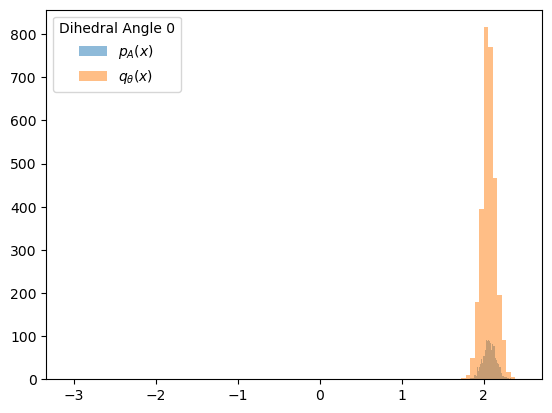

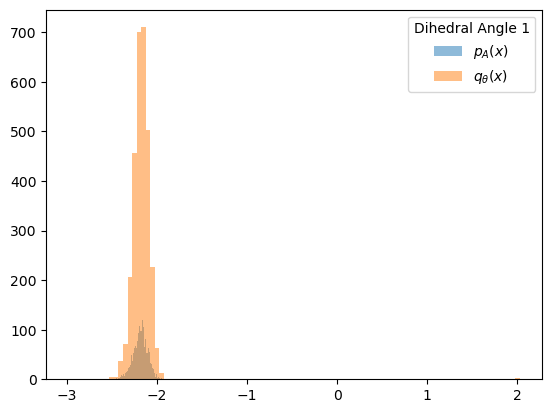

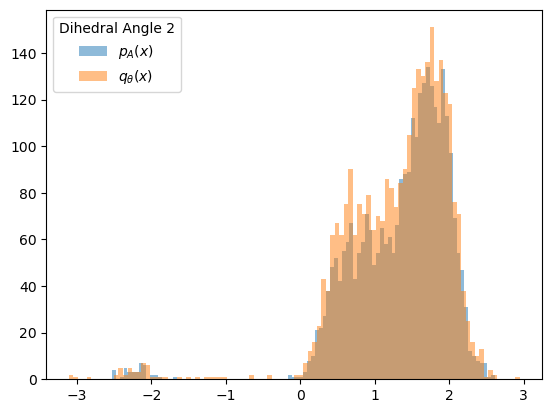

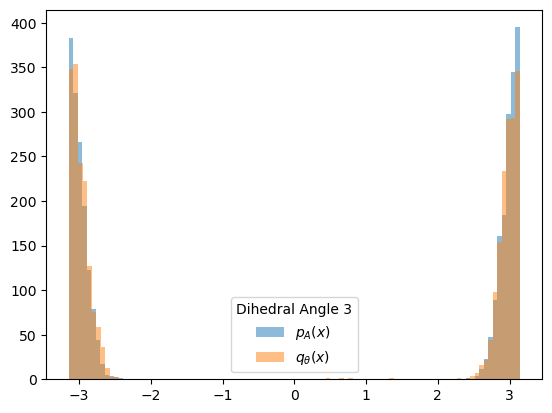

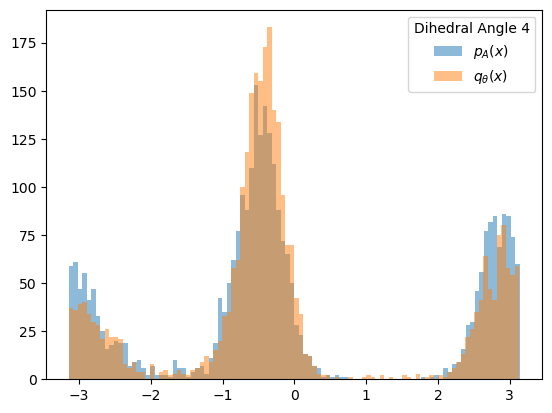

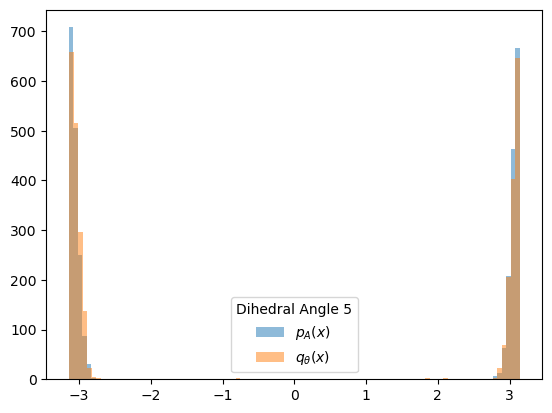

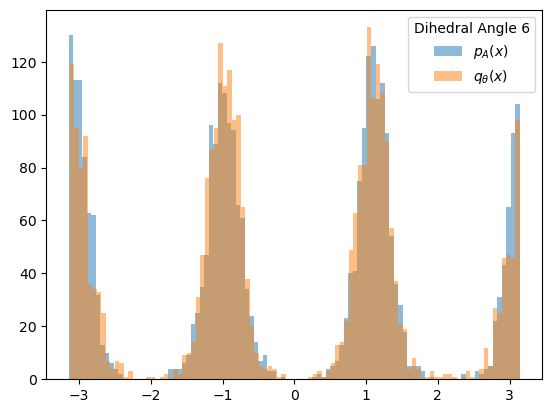

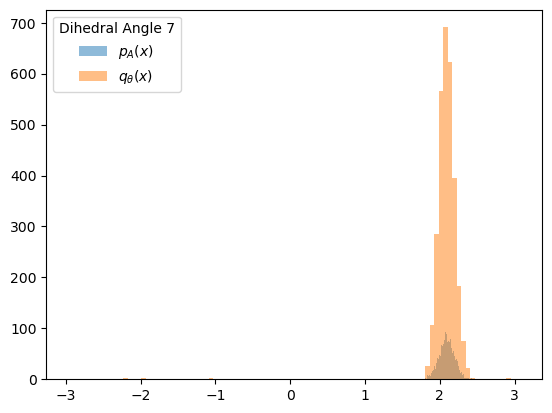

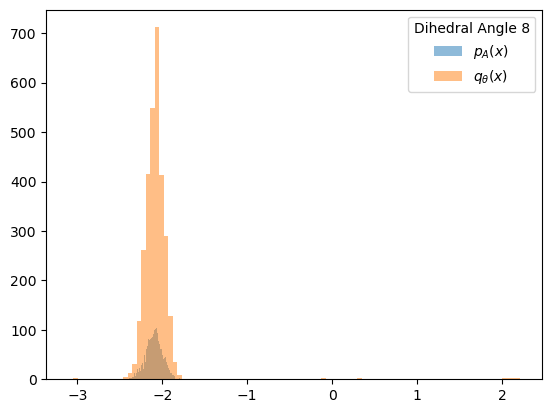

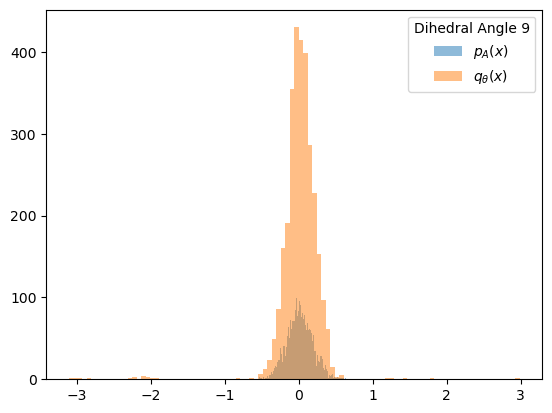

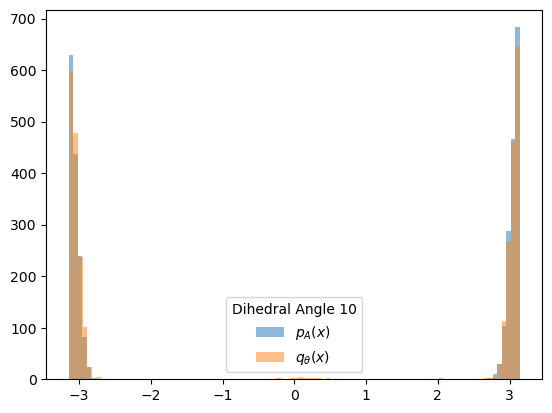

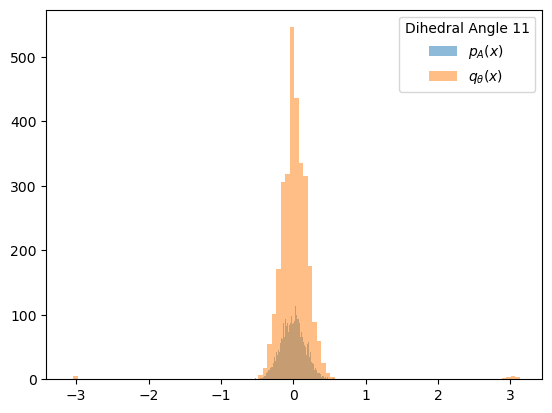

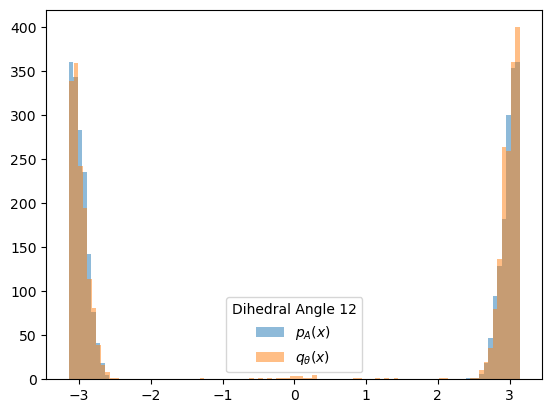

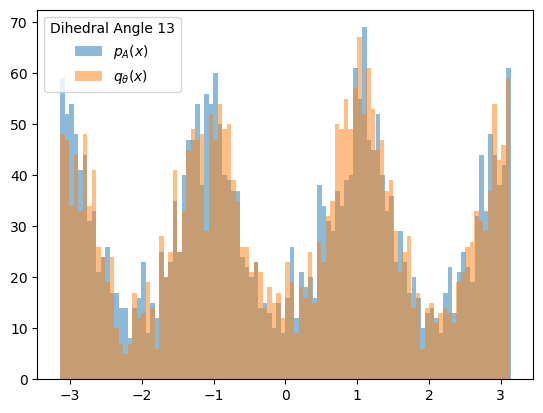

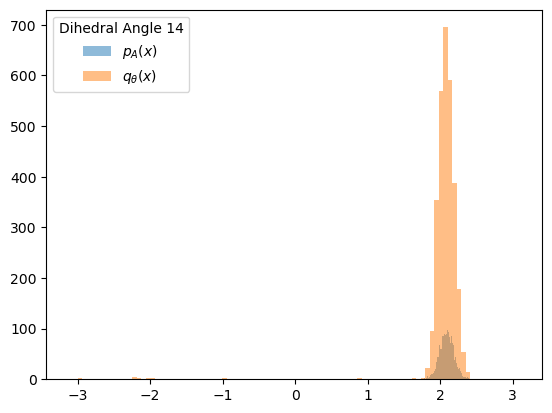

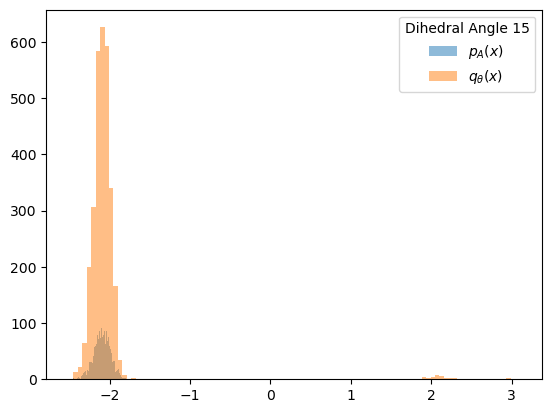

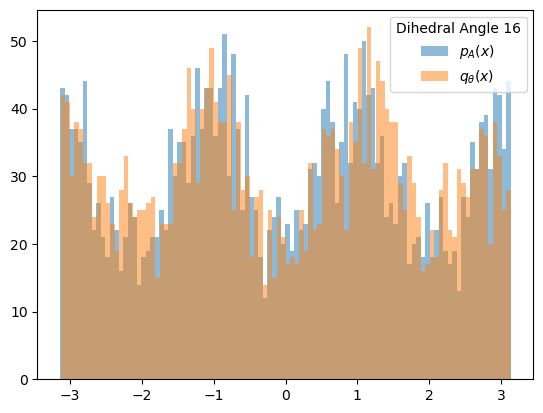

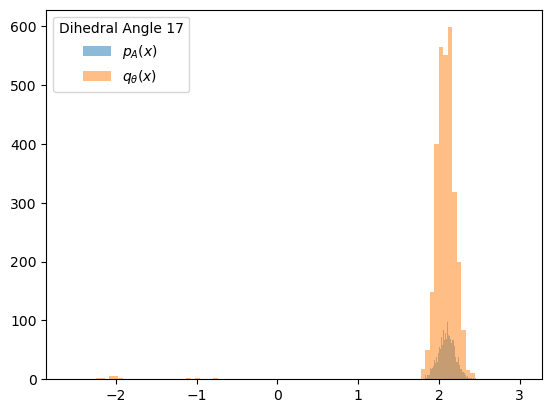

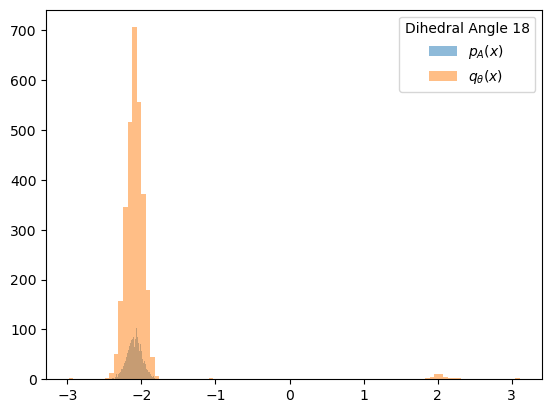

In [ ]:
for index in range(0, 19, 1):
    indx = str(index)

    plt.hist(np_data[:, index+41], label = "$p_A(x)$ ", bins = 100, alpha = 0.5)
    plt.hist(np_samples[:, index], label = "$q_\\theta(x)$ ", bins = 100, alpha = 0.5)
    
    plt.legend(title = "Dihedral Angle " + indx)
    plt.show()

In [ ]:
'''for index in range(0, 60, 1):
    plt.hist(np_data[:, index], label = index,bins = 200, alpha = 0.5)
    #plt.hist(np_samples[:, index], bins = 100, alpha=0.5)
    plt.show()'''

: 

### Calculate Energies

In [ ]:
raise Exception

In [ ]:
print(np.shape(np_samples))

: 

In [ ]:
print(np.shape(ba))

: 

In [ ]:
whole = np.concatenate((ba, np_samples), axis=1)

: 

In [ ]:
print(np.shape(whole))

: 

In [ ]:
molecules = rebuild(torch.tensor(whole))
potential_energy_q_theta = dataset_train.compute_potential_energy_for_ic(molecules)

: 

In [ ]:
potential_energy_md = np.concatenate(
    [dataset_train.potential_energy_kJ_per_mole,
     dataset_test.potential_energy_kJ_per_mole]
)

: 

In [ ]:
dataset_test = MMCDataset(root = './data',
                           molecule_name = name,
                           train = False,
                           coordinate_type = 'internal')

dataloader_test = DataLoader(dataset_test,
                              num_workers = 8,
                              batch_size = 1280,
                              shuffle = False)

: 

In [ ]:
p_x = np.concatenate(
    [dataset_train.potential_energy_kJ_per_mole,
     dataset_test.potential_energy_kJ_per_mole]
)

: 

In [ ]:
print(np.shape(p_x[2]))

: 

In [ ]:
plt.hist(potential_energy_q_theta, range =(-100, 100), bins = 100, alpha = 0.5, label = "$x \sim q_{\\theta}(x)$")
plt.hist(potential_energy_md[:2000], range =(-100, 100), bins = 100, alpha = 0.5, label = "$x \sim p_A(x)$")
plt.title("Energy Overlap of Autoregressive Jordan RNN \n and MD Simulations of Alanine Dipeptide, 2000 Samples")
plt.legend(prop={'size': 12})
plt.xlabel('Energies in $kJ \cdot mol^{-1}$')
plt.ylabel('Count')
plt.show()

: 